### Hard-Negative Sampling for Contrastive Learning in Emotion Classification
This code implements a contrastive learning approach with hard-negative sampling to improve the performance of an emotion classification model. The code ensures that at least two classes are present in the dataset, adding synthetic classes if necessary. It uses a smaller subset of the dataset and a reduced batch size to avoid kernel crashes. The model is a replica of that found in '3-Emoion-classifier.ipynb',built using EfficientNetB0 as the base network, and the training process includes gradient monitoring and gradient clipping to enhance stability. The code also includes functions to check for NaN values and convert DataLoader objects to NumPy arrays. The training process is monitored using callbacks for model checkpointing, early stopping, and learning rate reduction.

In [1]:
#Installation commands
#%pip install pandas opencv-python torch torchvision efficientnet_pytorch numpy matplotlib pytesseract scikit-learn dlib cmake seaborn
#%pip uninstall opencv-python opencv-python-headless
#%pip install keras
#%pip install tensorflow

# Relevant imports
import os
import sys
import shutil
import cv2
import dlib
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# PyTorch and torchvision
import torchvision 
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight

sys.setrecursionlimit(1500)
# Double check my class d   which pythonatasets are recognised:
os.listdir('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset')

['neutral-face', 'happy-face', 'sad-face', 'angry-face']

In [6]:
import sys
print(sys.executable)

/Users/nixi/Desktop/Final-thesis-folder-24/.conda/bin/python


### Data Pre-Processing
-  Remove any duplicates in 'my-classification-dataset' 
I had noticed a few duplicates when woorking with the same custom dataset for another data science module for k-means cluster experimentation. The private repository can be found here: https://git.arts.ac.uk/23002156/Intro-Data-Science-Portfolio-2024.
-  Isolating faces from images ( particularly for magazine data and to remove solely text data thta may have been collected during sampling)
I could exclude images with text using a text detector, but this may reduce the dataset significantly.
Use Haar Cascade classifier ( which uses feature based object detection) available from: https://github.com/opencv/opencv/tree/4.x/data/haarcascades.
- Create 'emotional-class-datasheet.csv', considering any new changes


-  Additional images derrived from https://www.kaggle.com/datasets/sudarshanvaidya/random-images-for-face-emotion-recognition?select=anger to ensure the ratio of images for each emotional class ,after cleaning, is over 1000 at the least.This aids in removing bias and better overall classification.

In [2]:
# How has this impacted my ratio?
emotional_classes = ['neutral-face', 'happy-face', 'sad-face', 'angry-face']

dirrectory = "/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset"

#Instantiate for counts
class_counts = {}

for emotion in emotional_classes:
    class_dir = os.path.join(dirrectory, emotion)
    # Count the number of image files in the class directory
    class_counts[emotion] = len([file for file in os.listdir(class_dir) if file.endswith(('jpg', 'jpeg', 'png', 'gif', 'bmp'))])


# Print out the value of each folder
for emotion_class, count in class_counts.items():
    print(f"Emotional class: {emotion_class}, Total images: {count}")

Emotional class: neutral-face, Total images: 1071
Emotional class: happy-face, Total images: 1100
Emotional class: sad-face, Total images: 1040
Emotional class: angry-face, Total images: 1025


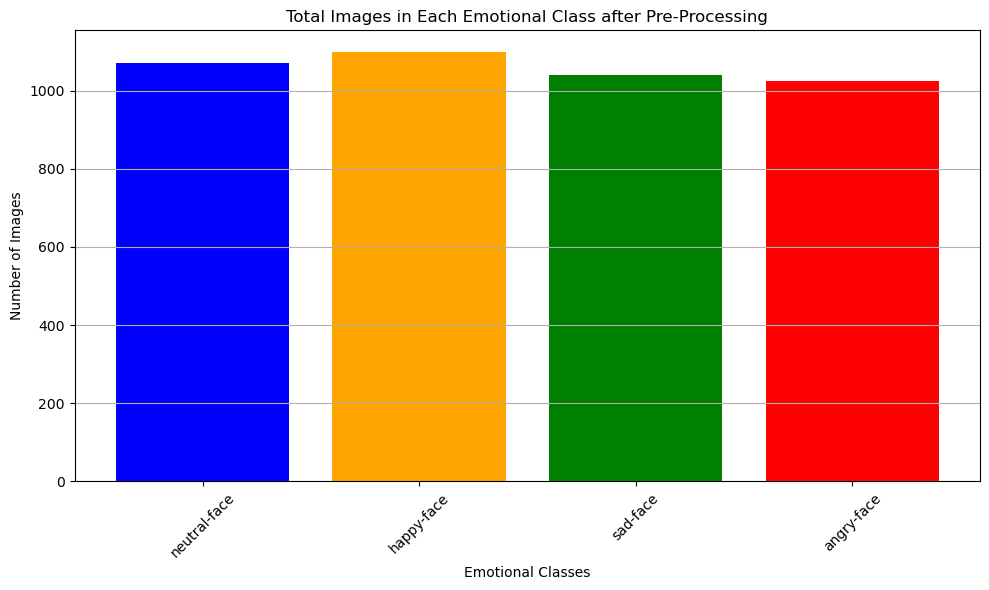

In [3]:
# Plotting the class balance after pre-processing and facial landmark detection
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange', 'green', 'red'])
plt.title('Total Images in Each Emotional Class after Pre-Processing')
plt.xlabel('Emotional Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')


plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import random

def create_pairs(images, labels, model=None):
    pairs = []
    labels_pairs = []
    num_classes = len(np.unique(labels))
    
    if num_classes < 2:
        raise ValueError("The dataset must contain at least two classes to create pairs.")
    
    class_indices = [np.where(labels == i)[0] for i in range(num_classes)]
    
    for idx1 in range(len(images)):
        current_image = images[idx1]
        label1 = labels[idx1]
        
        # Positive pair
        idx2 = random.choice(class_indices[label1])
        pos_image = images[idx2]
        
        pairs += [[current_image, pos_image]]
        labels_pairs += [1]
        
        # Hard-negative pair
        if model:
            # Get embeddings for all images
            embeddings = model.predict(images)
            current_embedding = embeddings[idx1]
            
            # Calculate distances to all other embeddings
            distances = np.linalg.norm(embeddings - current_embedding, axis=1)
            
            # Exclude positive samples
            distances[class_indices[label1]] = np.inf
            
            # Select the closest negative sample
            hard_neg_idx = np.argmin(distances)
            neg_image = images[hard_neg_idx]
        else:
            # Random negative pair if model is not provided
            neg_label = (label1 + random.randint(1, num_classes - 1)) % num_classes
            hard_neg_idx = random.choice(class_indices[neg_label])
            neg_image = images[hard_neg_idx]
        
        pairs += [[current_image, neg_image]]
        labels_pairs += [0]
    
    return np.array(pairs), np.array(labels_pairs)

### Make the Training and Validation set for training
I experimented with how to best split my dataset into train and validation sets, while maintaining the directory structure. I tried manually doing so, then using 'random_state= 42' as used in the class workbook which split data in a deterministic way. (See https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/tree/main/Week-3-CNNs-and-image-classification).

In [ ]:
# Code debugged with GPT
dataset_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-dataset'
output_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split'
train_ratio = 0.8

# Create output directories for train and validation sets
train_output_path = os.path.join(output_path, 'train')
val_output_path = os.path.join(output_path, 'validation')
os.makedirs(train_output_path, exist_ok=True)
os.makedirs(val_output_path, exist_ok=True)

# Dictionary to hold file paths by emotion class
class_files = {}

# Collect image and label files by emotion class
for root, dirs, files in os.walk(dataset_path):
    for f in files:
        if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.txt'):
            class_name = os.path.basename(root)
            if class_name not in class_files:
                class_files[class_name] = {'images': [], 'labels': []}
            file_path = os.path.join(root, f)
            if f.endswith('.jpg') or f.endswith('.png'):
                class_files[class_name]['images'].append(file_path)
            elif f.endswith('.txt'):
                class_files[class_name]['labels'].append(file_path)

# Perform train-test split for each class separately and copy the files
for class_name, files in class_files.items():
    train_image_files, val_image_files = train_test_split(files['images'], test_size=1 - train_ratio, random_state=42)
    train_label_files = [label_file for label_file in files['labels'] if os.path.splitext(label_file)[0] in train_image_files]
    val_label_files = [label_file for label_file in files['labels'] if os.path.splitext(label_file)[0] in val_image_files]

    # Copy training image and label files to the appropriate directory
    for train_image_file in train_image_files:
        relative_dir = os.path.relpath(os.path.dirname(train_image_file), dataset_path)
        target_dir = os.path.join(train_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(train_image_file, os.path.join(target_dir, os.path.basename(train_image_file)))

    for train_label_file in train_label_files:
        relative_dir = os.path.relpath(os.path.dirname(train_label_file), dataset_path)
        target_dir = os.path.join(train_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(train_label_file, os.path.join(target_dir, os.path.basename(train_label_file)))

    # Copy validation image and label files to the appropriate directory
    for val_image_file in val_image_files:
        relative_dir = os.path.relpath(os.path.dirname(val_image_file), dataset_path)
        target_dir = os.path.join(val_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(val_image_file, os.path.join(target_dir, os.path.basename(val_image_file)))

    for val_label_file in val_label_files:
        relative_dir = os.path.relpath(os.path.dirname(val_label_file), dataset_path)
        target_dir = os.path.join(val_output_path, relative_dir)
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(val_label_file, os.path.join(target_dir, os.path.basename(val_label_file)))

print("Data split into train and validation sets for each class.")

Data split into train and validation sets for each class.


In [5]:
# I had a folder called 'ipynb_checkpoints' that was considered a 7th emotional class but had no data within. This prevented the above code from working because file formats listed were not found at all.
# This seemed to be a reoccuring issue for image classification processes for other python users. This was found out at: https://forums.fast.ai/t/how-to-remove-ipynb-checkpoint/8532/27.
# I resorted to deleting the file overall and updating the training ( below code) from  7 classes to 6 and re-running training. ( code adapted from: https://stackoverflow.com/questions/61207135/how-can-i-ignore-or-remove-ipynb-checkpoints-in-colab)
dataset_dir = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split' 

# Remove the .ipynb_checkpoints directory if it exists
ipynb_checkpoints_dir = os.path.join(dataset_dir, '.ipynb_checkpoints')
if os.path.exists(ipynb_checkpoints_dir):
    os.rmdir(ipynb_checkpoints_dir)
    print(".ipynb_checkpoints directory deleted successfully.")
else:
    print(".ipynb_checkpoints directory not found.")

.ipynb_checkpoints directory not found.


In [6]:
# Code adapted from https://www.kaggle.com/code/akshitmadan/emotion-classification-cnn-using-keras.
picture_size = 150

folder_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/'

no_of_classes = 4 # total number of subfolders in my dataset ( each emotion)

batch_size = 300
datagen_train = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(os.path.join(folder_path, "train"),
                                              target_size=(picture_size, picture_size),
                                              color_mode="rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

test_set = datagen_val.flow_from_directory(os.path.join(folder_path, "validation"),
                                           target_size=(picture_size, picture_size),
                                           color_mode="rgb",
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=False)

Found 3587 images belonging to 4 classes.
Found 1115 images belonging to 4 classes.


### Train validation and training image transforms
This includes data augmentation using PyTorch and ImageDataGenerator from Kera, which are useful in creating variations in the image data. The following code has also been adapted from class week 3 CNN notebook as stated above.


Shape of train_numpy: (64, 150, 150, 3)


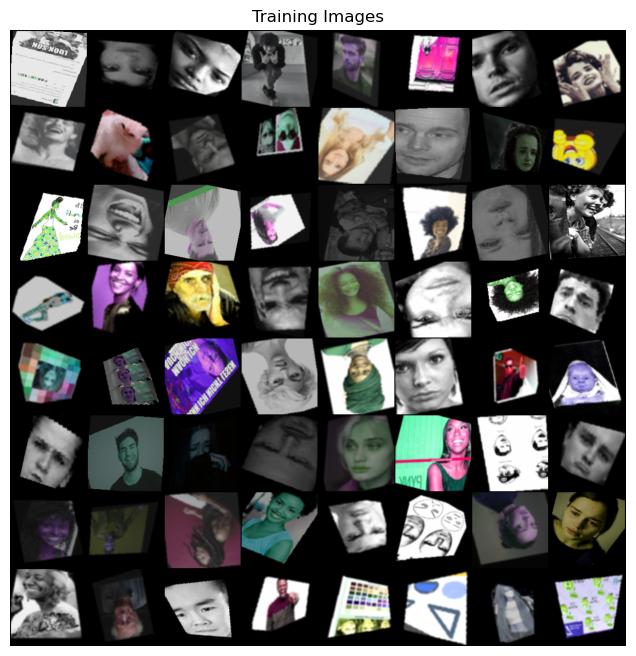

In [7]:
# Define train_transform for data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=(-30, 30), translate=(0.15, 0.15), scale=(0.85, 1.15)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomResizedCrop(size=(150, 150), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    #transforms.Grayscale(num_output_channels=1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)), # Experimented with new transforms (Gaussian Blur. code adapted from https://pytorch.org/vision/main/generated/torchvision.transforms.GaussianBlur.html)
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the directory to your training dataset
train_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train'

# Load the training dataset
train_set = torchvision.datasets.ImageFolder(root=train_path, transform=train_transform)

# Define DataLoader for batch loading
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Get a batch of training images
real_batch = next(iter(train_loader))
tensor_batch = real_batch[0]

# Convert a batch of PyTorch tensors to NumPy arrays
# Convert PyTorch tensors to NumPy arrays (had to convert PyTorch tensor to NumPy array, due to incorrect data processing.
# I used code adapted from: https://www.geeksforgeeks.org/how-to-convert-pytorch-tensor-to-numpy-array/ then debugged with GPT after my own attempt.

train_numpy = tensor_batch.numpy()
train_numpy = np.moveaxis(train_numpy, 1, -1)
print("Shape of train_numpy:", train_numpy.shape)

# Plot some training images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")

# Display the grid of images 
# The below code was adapted from https://stackoverflow.com/questions/51329159/how-can-i-generate-and-display-a-grid-of-images-in-pytorch-with-plt-imshow-and-t, which explained the same issue where matplotlib was not displaying my images because of image sizing differences.
plt.imshow(make_grid(tensor_batch, padding=2, normalize=True).permute(1, 2, 0).cpu().numpy())
plt.show()

Shape of val_numpy: (1115, 150, 150, 3)


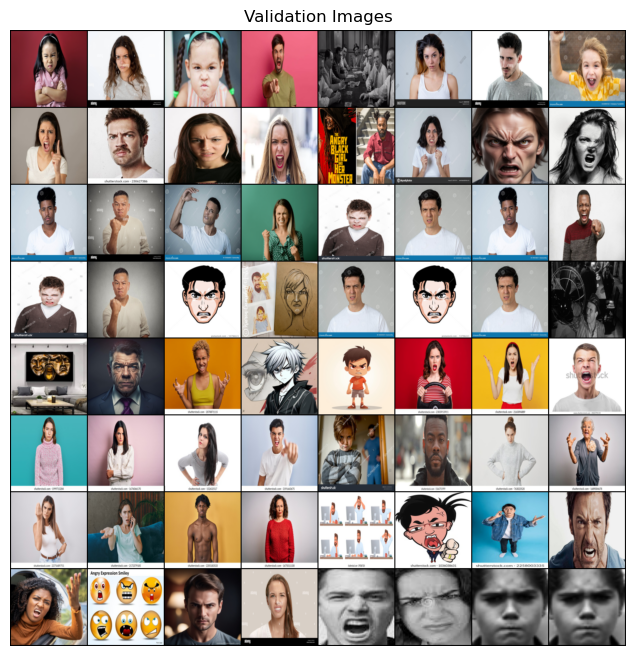

In [8]:
# Validation image transforms using the similar approach as train
import torchvision.datasets as datasets

val_transform = transforms.Compose([
    torchvision.transforms.Resize((150, 150)), 
    #transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the directory to your validation dataset
val_path = '/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation'  # Path to the directory containing class directories

val_set = torchvision.datasets.ImageFolder(root=val_path, transform=val_transform)

# Convert to NumPy array for data processing ( same as the above training data)
# I had an issue with the dimensions of my images
val_numpy = np.array([x.numpy() for x, _ in val_set])

# Code adapted from: https://stackoverflow.com/questions/57438392/rearranging-axes-in-numpy after an error with the shape of val_numpy (374, 1, 150, 150).
    # The error: 'sequential_9". I have an error 'ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 150, 150, 1), found shape=(None, 1, 150, 150)'
val_numpy = np.moveaxis(val_numpy, 1, -1)
print("Shape of val_numpy:", val_numpy.shape)

# Define DataLoader for batch loading
batch_size = 64
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Get a batch of validation images
real_batch = next(iter(val_loader))

# Convert torch tensor to numpy array and permute the dimensions to match (batch_size, height, width, channels)
tensor_batch = real_batch[0]

# Plot some validation images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Validation Images")

# The code below displays the batch of images using matplotlib
plt.imshow(make_grid(tensor_batch, padding=2, normalize=True).permute(1, 2, 0).cpu().numpy())
plt.show()

### Define and Train Model

In [9]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to 150x150
    transforms.Grayscale(),          # Convert to grayscale if needed
    transforms.ToTensor(),           # Convert to tensor
])

# Define the dataset
train_set = datasets.ImageFolder(root='/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train', transform=transform)
val_set = datasets.ImageFolder(root='/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation', transform=transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Convert DataLoader to NumPy arrays for training and validation sets
train_numpy = []
train_labels = []

for data, labels in train_loader:
    data = data.numpy().transpose(0, 2, 3, 1)  # Convert to (batch_size, height, width, channels)
    train_numpy.append(data)
    train_labels.extend(labels.numpy().flatten())

train_numpy = np.concatenate(train_numpy, axis=0)
train_labels = np.array(train_labels)

print("Train set converted!")
print("Train numpy shape:", train_numpy.shape)
print("Train labels shape:", train_labels.shape)

# Repeat for validation set
val_numpy = []
val_labels = []

for data, labels in val_loader:
    data = data.numpy().transpose(0, 2, 3, 1)
    val_numpy.append(data)
    val_labels.extend(labels.numpy().flatten())

val_numpy = np.concatenate(val_numpy, axis=0)
val_labels = np.array(val_labels)

print("Validation set converted!")
print("Validation numpy shape:", val_numpy.shape)
print("Validation labels shape:", val_labels.shape)

Train set converted!
Train numpy shape: (3587, 150, 150, 1)
Train labels shape: (3587,)
Validation set converted!
Validation numpy shape: (1115, 150, 150, 1)
Validation labels shape: (1115,)


In [10]:
# Convert grayscale (1 channel) to RGB (3 channels)
train_numpy_rgb = np.repeat(train_numpy, 3, axis=-1)  # Repeat the grayscale channel 3 times
val_numpy_rgb = np.repeat(val_numpy, 3, axis=-1)  # Repeat the grayscale channel 3 times

train_labels_categorical = to_categorical(train_labels, num_classes=4)  
val_labels_categorical = to_categorical(val_labels, num_classes=4)

# Compute class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Ensure shapes are correct for EfficientNetB0 input
print("Train numpy RGB shape:", train_numpy_rgb.shape)  # Should be (3587, 150, 150, 3)
print("Validation numpy RGB shape:", val_numpy_rgb.shape)  # Should be (1115, 150, 150, 3)


Train numpy RGB shape: (3587, 150, 150, 3)
Validation numpy RGB shape: (1115, 150, 150, 3)


Train numpy RGB shape: (3587, 150, 150, 3)
Validation numpy RGB shape: (1115, 150, 150, 3)
Training with frozen EfficientNetB0 base model...
Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.3039 - loss: 2.0583 - val_accuracy: 0.1928 - val_loss: 1.7851 - learning_rate: 0.0010
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.3889 - loss: 1.7209 - val_accuracy: 0.1928 - val_loss: 1.8112 - learning_rate: 0.0010
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.4908 - loss: 1.5451 - val_accuracy: 0.3076 - val_loss: 1.7982 - learning_rate: 0.0010
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6000 - loss: 1.3479 - val_accuracy: 0.3354 - val_loss: 1.8382 - learning_rate: 0.0010
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.6711 - loss: 1.1808 - val_accuracy: 0.4027 - val_loss: 1.7176 - learning_rate: 0.0010
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.7244 - loss: 1.0567 - val_a

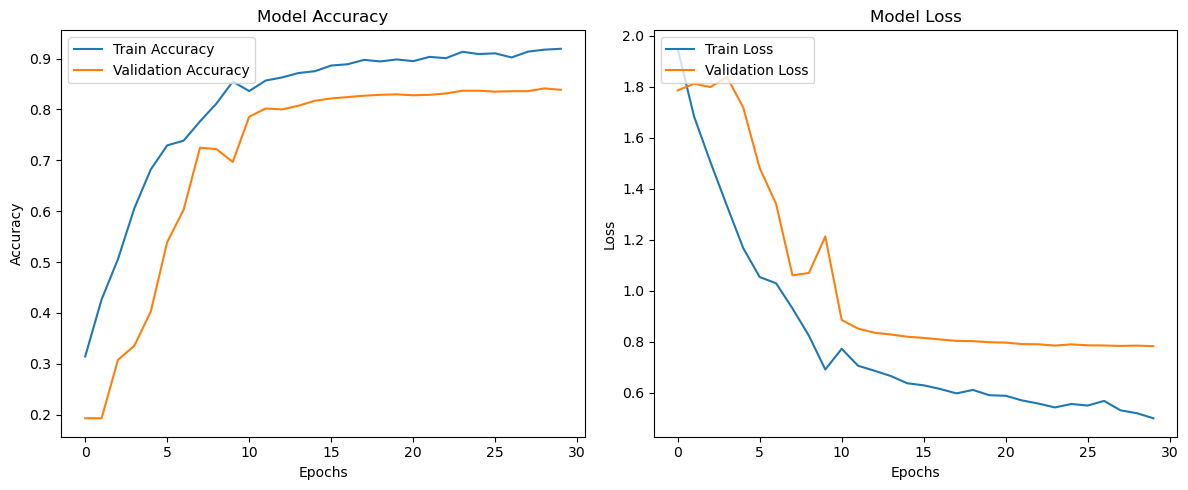

In [11]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# Define transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to 150x150
    transforms.Grayscale(),          # Convert to grayscale if needed
    transforms.ToTensor(),           # Convert to tensor
])

# Define the dataset
train_set = datasets.ImageFolder(root='/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/train', transform=transform)
val_set = datasets.ImageFolder(root='/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/my-classification-split/validation', transform=transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Convert DataLoader to NumPy arrays for training and validation sets
def convert_to_numpy(loader):
    data_list = []
    labels_list = []
    for data, labels in loader:
        data = data.numpy().transpose(0, 2, 3, 1)  # Convert to (batch_size, height, width, channels)
        data_list.append(data)
        labels_list.extend(labels.numpy().flatten())
    data_numpy = np.concatenate(data_list, axis=0)
    labels_numpy = np.array(labels_list)
    return data_numpy, labels_numpy

train_numpy, train_labels = convert_to_numpy(train_loader)
val_numpy, val_labels = convert_to_numpy(val_loader)

# Convert grayscale (1 channel) to RGB (3 channels)
train_numpy_rgb = np.repeat(train_numpy, 3, axis=-1)  # Repeat the grayscale channel 3 times
val_numpy_rgb = np.repeat(val_numpy, 3, axis=-1)  # Repeat the grayscale channel 3 times

# One-hot encode the labels
num_classes = 4  # Update this to match the number of classes in your dataset
train_labels_categorical = to_categorical(train_labels, num_classes)
val_labels_categorical = to_categorical(val_labels, num_classes)

# Compute class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Ensure shapes are correct for EfficientNetB0 input
print("Train numpy RGB shape:", train_numpy_rgb.shape)  # Should be (3123, 150, 150, 3)
print("Validation numpy RGB shape:", val_numpy_rgb.shape)  # Should be (783, 150, 150, 3)

# Define the model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = True  # unFreeze the base model

model = Sequential([
    base_model,  # Include the EfficientNetB0 pre-trained layers with L2 regularization
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),  # added dropout for deeper layering that increases as the model goes on.
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(512, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model with a higher initial learning rate
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks_list = [
    ModelCheckpoint("model_weights.keras", monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
]

# Train the model with the frozen EfficientNetB0 base
print("Training with frozen EfficientNetB0 base model...")
history_frozen = model.fit(
    train_numpy_rgb,  # Training images in RGB format
    train_labels_categorical,  # Training labels
    validation_data=(val_numpy_rgb, val_labels_categorical),  # Correct validation images and labels
    class_weight=class_weight_dict,  # uses class weights computed above
    epochs=10,  # increased epochs
    callbacks=callbacks_list
)

# Fine-tune some EfficientNetB0 layers
print("Fine-tuning the EfficientNetB0 model...")
base_model.trainable = True  # Unfreeze the base model

# Freeze all but the last few layers of EfficientNetB0
for layer in base_model.layers[:-90]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with unfrozen layers
history_unfrozen = model.fit(
    train_numpy_rgb,
    train_labels_categorical,
    validation_data=(val_numpy_rgb, val_labels_categorical),
    class_weight=class_weight_dict,
    epochs=20,
    callbacks=callbacks_list
)

# Combine the histories
history = {}
for k in history_frozen.history.keys():
    history[k] = history_frozen.history[k] + history_unfrozen.history[k]

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 728ms/step
Shape of true_labels: (1115,)
First few true labels: [0 0 0 0 0]
Shape of predicted_labels: (1115,)
First few predicted labels: [0 0 0 0 0]


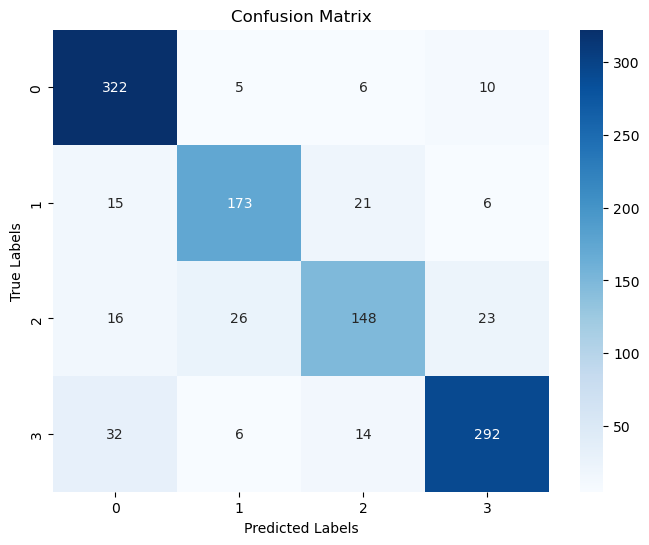

In [12]:
# save model
# Code adapted from: https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/blob/main/Week-4-Sensing-bodies/02-train-keypoints-classifier.ipynb.
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make Prediction
predictions = model.predict(val_numpy)
predicted_labels = np.argmax(predictions, axis=1)

#Convert Predictions and True Labels
true_labels = np.argmax(val_labels_categorical, axis=1)  

print("Shape of true_labels:", true_labels.shape)
print("First few true labels:", true_labels[:5])
print("Shape of predicted_labels:", predicted_labels.shape)
print("First few predicted labels:", predicted_labels[:5])

#Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

#Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
model.save('final_model.h5')

Train numpy RGB shape: (3123, 150, 150, 3)
Validation numpy RGB shape: (783, 150, 150, 3)
Training with frozen EfficientNetB0 base model...
Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 40s 335ms/step - accuracy: 0.2467 - loss: 2.2119 - val_accuracy: 0.2746 - val_loss: 1.7584 - learning_rate: 0.0010
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 260ms/step - accuracy: 0.2365 - loss: 2.0883 - val_accuracy: 0.2146 - val_loss: 1.7501 - learning_rate: 0.0010
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - accuracy: 0.2586 - loss: 1.9340 - val_accuracy: 0.2720 - val_loss: 1.7061 - learning_rate: 0.0010
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - accuracy: 0.2451 - loss: 1.8975 - val_accuracy: 0.2388 - val_loss: 1.6912 - learning_rate: 0.0010
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 0.2501 - loss: 1.8141 - val_accuracy: 0.2746 - val_loss: 1.6725 - learning_rate: 0.0010
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - accuracy: 0.2664 - loss: 1.7596 - 

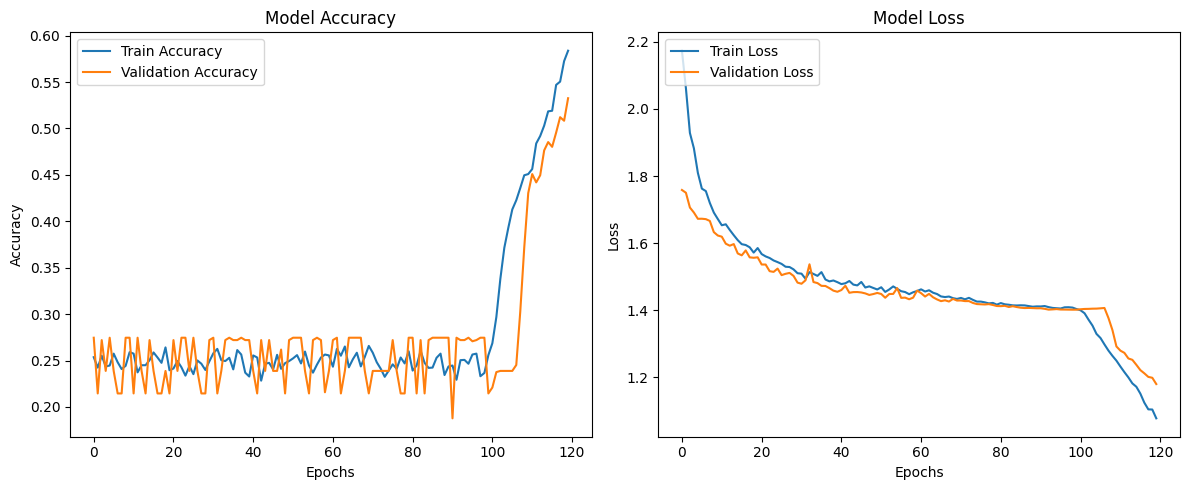

In [ ]:
# Code adapted from: https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7 and debugged with GPT for resampling issues.
# I ran into a 'ValueError: Failed to find data adapter that can handle input: <class 'torchvision.datasets.folder.ImageFolder'>, <class 'NoneType'>' which suggested my data for the training and validation were not in an expected format before passing them into the model.fit() function
# The next two lines of code were suggested by GPT, converting PyTorch dataset to MumPy arrays, which then can be used with Keras.

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze the base model

# VGG16 base model
model = Sequential([
    base_model,  # Include the EfficientNetB0 pre-trained layers with L2 regularization
    #GlobalAveragePooling2D(), # helps reduce spatial dimensiona
    Conv2D(32, (3, 3), padding='same',kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3), # added dropout for deeper layering that increases as the model goes on.
        
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
        
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
        
    # Flatten the feature maps to feed into fully connected layers
    Flatten(),
        
    # Fully connected layer with L2 regularization and dropout
    Dense(512, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
        
    # Output layer for 4 emotion classification classes 
    Dense(4, activation='softmax')])

# Compile the model with a higher initial learning rate
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks_list = [
    ModelCheckpoint("model_weights.keras", monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)]

#Train the model with the frozen EfficientNetB0 base
print("Training with frozen EfficientNetB0 base model...")
history_frozen = model.fit(
    train_numpy_rgb,  # Training images in RGB format
    train_labels_categorical,  # Training labels
    validation_data=(val_numpy_rgb, val_labels_categorical),  # Correct validation images and labels
    class_weight=class_weight_dict, # uses class weights computed above
    epochs=100, # increased epochs
    callbacks=callbacks_list)

# Fine-tune some EfficientNetB0 layers
print("Fine-tuning the EfficientNetB0 model...")
base_model.trainable = True  # Unfreeze the base model

# Freeze all but the last few layers of EfficientNetB0
for layer in base_model.layers[:-10]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with unfrozen layers
history_unfrozen = model.fit(
    train_numpy_rgb,
    train_labels_categorical,
    validation_data=(val_numpy_rgb, val_labels_categorical),
    class_weight=class_weight_dict,
    epochs=20,
    callbacks=callbacks_list)


# Combine the histories
history = {}
for k in history_frozen.history.keys():
    history[k] = history_frozen.history[k] + history_unfrozen.history[k]

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

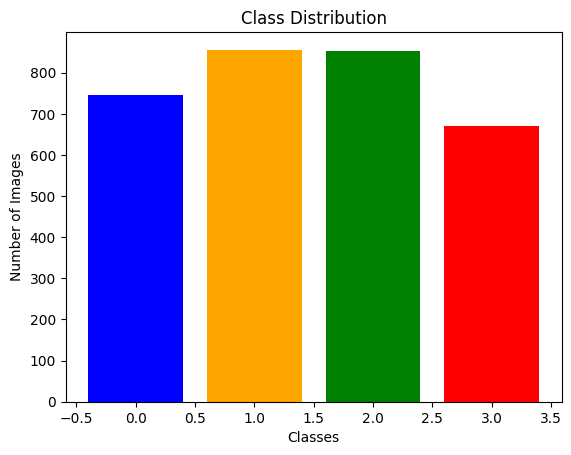

In [ ]:
# Analyse the distribution of data for each emotional class
unique, counts = np.unique(train_labels, return_counts=True)
colors = ['blue', 'orange', 'green', 'red'] # added color=['blue', 'orange', 'green', 'red'] to correspond with the classes throughout

plt.bar(unique, counts, color=colors)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

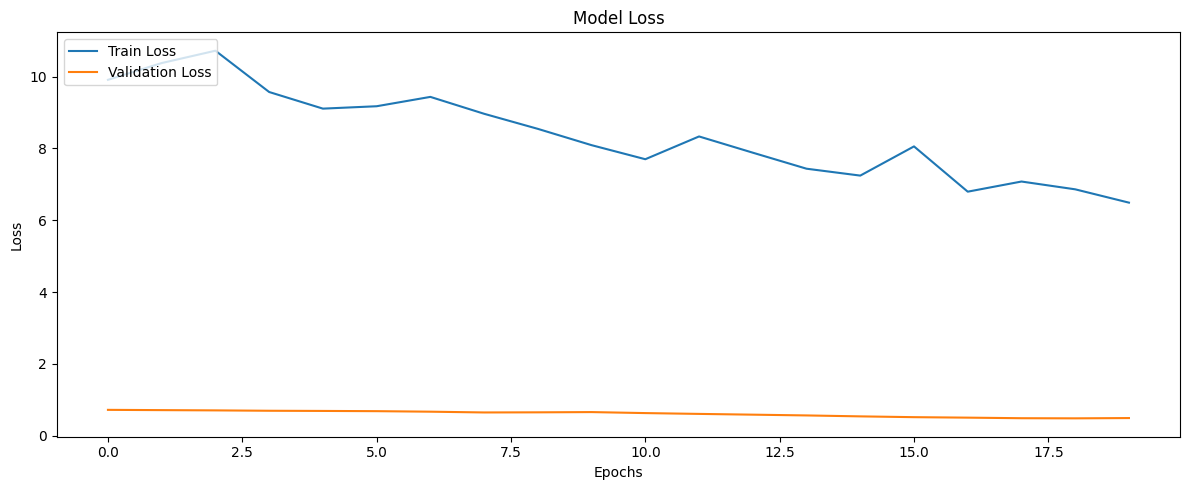

In [3]:
# Plot loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Works cite:
- Win, K.C., Akhtar, Z. and Mohan, C.K.(2024). Does Hard-Negative Contrastive Learning Improve Facial Emotion Recognition?. In Proceedings of the 2024 7th International Conference on Machine Vision and Applications, 162-168. Available at: https://dl.acm.org/doi/abs/10.1145/3653946.3653971. [Accessed 27 June 2024]. 
